<a href="https://colab.research.google.com/github/JoshuaGreeff/Spam-Detection/blob/main/Transformer_based_NLP_U599.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set up Kaggle config and base directory
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"
base_dir = '/content/drive/MyDrive/U599 Project'

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# CD to the testing directory
%mkdir ~/testing
%cd ~/testing

# Check CUDA status
!nvidia-smi

Mounted at /content/drive
/root/testing
Wed Mar  5 14:08:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-------

In [ ]:
# Install necessary packages quietly
!pip install -q evaluate datasets onnx onnxscript onnxruntime

# Imports
import torch
import kagglehub
import pandas as pd
import re
import numpy as np
import shutil
import datasets
import evaluate
import time

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss

from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    EarlyStoppingCallback,
    get_linear_schedule_with_warmup,
    TrainingArguments,
    Trainer
)

from onnxruntime import InferenceSession
import onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 24.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 694.9/694.9 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 4.4 MB/s eta 0:00:00


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [ ]:
# Download dataset from Kaggle and load CSV
dataset_path = kagglehub.dataset_download("subhajournal/phishingemails")
csv_filename = os.path.join(dataset_path, "Phishing_Email.csv")
df = pd.read_csv(csv_filename)
print(df.info())
df.head()

100%|██████████| 18.0M/18.0M [00:01<00:00, 9.67MB/s]

Extracting files...


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  18650 non-null  int64 
 1   Email Text  18634 non-null  object
 2   Email Type  18650 non-null  object
dtypes: int64(1), object(2)
memory usage: 437.2+ KB
None


,Unnamed: 0,Email Text,Email Type
0,0,"re : 6 . 1100 , disc : uniformitarianism , re ...",Safe Email
1,1,the other side of * galicismos * * galicismo *...,Safe Email
2,2,re : equistar deal tickets are you still avail...,Safe Email
3,3,\nHello I am your hot lil horny toy.\n I am...,Phishing Email
4,4,software at incredibly low prices ( 86 % lower...,Phishing Email


In [ ]:
# Track data changes through cleaning steps
data_changes = {}
data_changes["Original"] = len(df)
df.drop(columns=["Unnamed: 0"], inplace=True)
df.drop_duplicates(inplace=True)
df.dropna(inplace=True)
data_changes["After Removing Duplicates & Null"] = len(df)

# Remove noise by filtering out outlier email lengths for each Email Type
df['length'] = df['Email Text'].str.len()
for email_type in df["Email Type"].unique():
    lengths = df.loc[df["Email Type"] == email_type, "length"]
    q1 = lengths.quantile(0.25)
    q3 = lengths.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    outliers = lengths[(lengths < lower) | (lengths > upper)].index
    df.drop(index=outliers, inplace=True)
data_changes["After Noise Removal"] = len(df)
df.drop(columns=["length"], inplace=True)
df.reset_index(drop=True, inplace=True)
data_changes["Final"] = len(df)

print("Data Changes Tracking:")
for stage, size in data_changes.items():
    print(f"{stage}: {size} rows")
print(pd.DataFrame(list(data_changes.items()), columns=["Stage", "Row Count"]))

def preprocess_text(text: str) -> str:
    # Lowercase the text
    text = text.lower()
    # Remove special characters and punctuation (retain numbers)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    # Replace numbers with a hashtag
    text = re.sub(r'\d+', '#', text)
    # Remove extra spaces/newlines
    return re.sub(r'\s+', ' ', text).strip()

df['Email Text'] = df['Email Text'].apply(preprocess_text)
df.head()

Data Changes Tracking:
Original: 18650 rows
After Removing Duplicates & Null: 17538 rows
After Noise Removal: 15895 rows
Final: 15895 rows
                              Stage  Row Count
0                          Original      18650
1  After Removing Duplicates & Null      17538
2               After Noise Removal      15895
3                             Final      15895


,Email Text,Email Type
0,re # # disc uniformitarianism re # sex lang di...,Safe Email
1,the other side of galicismos galicismo is a sp...,Safe Email
2,re equistar deal tickets are you still availab...,Safe Email
3,hello i am your hot lil horny toy i am the one...,Phishing Email
4,software at incredibly low prices # lower drap...,Phishing Email


In [ ]:
# Split the data into training, validation, and test sets
train_df, temp_df = train_test_split(df, stratify=df["Email Type"], test_size=0.2, random_state=123)
valid_df, test_df = train_test_split(temp_df, stratify=temp_df["Email Type"], test_size=0.5, random_state=123)
print("Train, Valid, Test shapes:", train_df.shape, valid_df.shape, test_df.shape)

# Convert to Hugging Face datasets
dataset = datasets.DatasetDict({
    "train": datasets.Dataset.from_pandas(train_df),
    "valid": datasets.Dataset.from_pandas(valid_df),
    "test": datasets.Dataset.from_pandas(test_df)
})
if "__index_level_0__" in dataset["train"].column_names:
    dataset = dataset.remove_columns(["__index_level_0__"])

# Define label mappings and add numeric labels to the dataset
id2label = {0: "Safe Email", 1: "Phishing Email"}
label2id = {"Safe Email": 0, "Phishing Email": 1}

def add_labels(example):
    example['labels'] = label2id[example['Email Type']]
    return example

dataset = dataset.map(add_labels)

# Tokenization using a model
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_function(example):
    return tokenizer(example["Email Text"], padding="max_length", truncation=True)

dataset_tokenized = dataset.map(tokenize_function, batched=True)
dataset_tokenized = dataset_tokenized.remove_columns(["Email Type"])

dataset_tokenized

Train, Valid, Test shapes: (12716, 2) (1589, 2) (1590, 2)


Map:   0%|          | 0/12716 [00:00<?, ? examples/s]

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/12716 [00:00<?, ? examples/s]

Map:   0%|          | 0/1589 [00:00<?, ? examples/s]

Map:   0%|          | 0/1590 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Email Text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 12716
    })
    valid: Dataset({
        features: ['Email Text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1589
    })
    test: Dataset({
        features: ['Email Text', 'labels', 'input_ids', 'attention_mask'],
        num_rows: 1590
    })
})

In [ ]:
print("GPU available:", torch.cuda.is_available())

# Load transformer model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)
model.to(device)

# Load evaluation metric and define compute_metrics
metric = evaluate.load('f1')
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)

    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions, average='binary')
    recall = recall_score(labels, predictions, average='binary')
    f1 = f1_score(labels, predictions, average='binary')
    auc = roc_auc_score(labels, logits[:, 1])  # Use probabilities for AUC
    logloss = log_loss(labels, logits[:, 1])   # Use probabilities for log loss
    conf_matrix = confusion_matrix(labels, predictions)

    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "roc_auc": auc,
        "log_loss": logloss,
        "confusion_matrix": conf_matrix.tolist()  # Convert to list for logging
    }

# Set up TrainingArguments (default values omitted where possible)
training_args = TrainingArguments(
    output_dir="save_model",
    num_train_epochs=10,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    load_best_model_at_end=True,
    eval_strategy="epoch",
    metric_for_best_model="eval_loss",
    save_strategy="epoch",
    fp16=torch.cuda.is_available(),
    report_to="none"
)

# Create Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_tokenized['train'],
    eval_dataset=dataset_tokenized['valid'],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

# Set up optimizer and scheduler

# AdamW optimizer is widely regarded as the industry standard.
# AdamW is an adaptive optimizer that combines the benefits of the Adam
# optimizer with weight decay regularization, which helps prevent overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=training_args.learning_rate)

# This scheduler linearly increases the learning rate during the warm-up phase
# and then decreases it, which can lead to better convergence.
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=training_args.warmup_steps,
    num_training_steps=len(trainer.get_train_dataloader()) * training_args.num_train_epochs
)
trainer.optimizer = optimizer
trainer.lr_scheduler = scheduler

# Train the model
start_time = time.time()
trainer.train()
end_time = time.time()
training_time = end_time - start_time
print(f"Total training time: {training_time:.2f} seconds")

# Predict on the test set and evaluate F1 score
pred_output = trainer.predict(dataset_tokenized['test'])
y_pred = np.argmax(pred_output.predictions, axis=1)
f1 = evaluate.load('f1').compute(predictions=y_pred, references=dataset_tokenized['test']['labels'])['f1']
print(f"F1 Score: {f1:.4f}")

GPU available: True


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1,Roc Auc,Log Loss,Confusion Matrix,Runtime,Samples Per Second,Steps Per Second
1,No log,0.074719,0.976086,0.980836,0.954237,0.967354,0.997939,0.322570,"[[988, 11], [27, 563]]",6.089300,260.949000,4.106000
2,0.197400,0.070547,0.979862,0.992933,0.952542,0.972318,0.999294,0.335718,"[[995, 4], [28, 562]]",6.421900,247.433000,3.893000
3,0.038500,0.120684,0.976086,0.943730,0.994915,0.968647,0.998731,0.342629,"[[964, 35], [3, 587]]",6.240700,254.618000,4.006000
4,0.011600,0.039577,0.988043,0.986371,0.981356,0.983857,0.999600,0.176814,"[[991, 8], [11, 579]]",6.352500,250.138000,3.935000
5,0.011600,0.064975,0.986784,0.993068,0.971186,0.982005,0.999503,0.206162,"[[995, 4], [17, 573]]",6.467000,245.708000,3.866000
6,0.004200,0.068256,0.988043,0.984720,0.983051,0.983885,0.999369,0.184765,"[[990, 9], [10, 580]]",6.075200,261.557000,4.115000
7,0.001300,0.067515,0.988043,0.983080,0.984746,0.983912,0.999495,0.173356,"[[989, 10], [9, 581]]",6.428200,247.193000,3.889000


Total training time: 1131.73 seconds


F1 Score: 0.9806


In [ ]:
# Testing and Validating the PyTorch Model

# Define a function to predict spam from raw text
def predict_spam(text: str) -> str:
    inputs = tokenizer(text, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        logits = model(**inputs).logits
    pred = logits.argmax().item()
    return model.config.id2label[pred]

# Run predictions
test1result = predict_spam("you got a free credit click to this link to get it")
test2result = predict_spam("hey jack can you send me the invoice from yesterday")

# Print results
print(f"Test 1 Result: {test1result}")
print(f"Test 2 Result: {test2result}")

Test 1 Result: Phishing Email
Test 2 Result: Safe Email


In [ ]:
# ONNX Export and Inference

# Prepare a sample input and move model to CPU for export
inputs = tokenizer("Sample", return_tensors="pt", padding=True, truncation=True, max_length=128)
model.to("cpu")
model.eval()

onnx_file_name = "nlp-model-2.onnx"
drive_path = '/content/drive/My Drive/U599 Project/ONNX Models/'

# Define path to save the tokenizer
tokenizer_path = "/content/drive/My Drive/U599 Project/ONNX Utils/tokenizer-2"

# Save the tokenizer
tokenizer.save_pretrained(tokenizer_path)
print(f"BERT Tokenizer saved to: {tokenizer_path}")


torch.onnx.export(
    model,
    (inputs["input_ids"], inputs["attention_mask"]),
    onnx_file_name,
    input_names=["input_ids", "attention_mask"],
    output_names=["logits"],
    dynamic_axes={
        "input_ids": {0: "batch_size", 1: "sequence_length"},
        "attention_mask": {0: "batch_size", 1: "sequence_length"},
        "logits": {0: "batch_size"}
    },
    opset_version=14
)

# Verify the exported ONNX model
onnx_model = onnx.load(onnx_file_name)
onnx.checker.check_model(onnx_model)

# Save the ONNX model to Google Drive
os.makedirs(drive_path, exist_ok=True)
shutil.copy(onnx_file_name, drive_path)
print(f"ONNX model saved to: {drive_path}")

# Load the ONNX model and test inference
session = InferenceSession(onnx_file_name)

# Onnx Inference function
def predict_spam_onnx(text: str) -> str:
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    ort_inputs = {
        session.get_inputs()[0].name: inputs['input_ids'].cpu().numpy(),
        session.get_inputs()[1].name: inputs['attention_mask'].cpu().numpy()
    }
    start_time = time.time()
    ort_outs = session.run(None, ort_inputs)
    end_time = time.time()
    predicting_time = end_time - start_time

    predicted_label_index = np.argmax(ort_outs[0], axis=1)[0]
    predicted_label = model.config.id2label[predicted_label_index]
    return predicted_label, predicting_time

# Perform inference with ONNX Runtime on custom text
custom_text = "you got a free credit click to this link to get it"
predicted_label, predicting_time1 = predict_spam_onnx(custom_text)
print(f"Result 1 ONNX model: {predicted_label} | Same as Pytorch: {predicted_label==test1result} | Time taken: {predicting_time1:.2f}")

custom_text = "hey jack can you send me the invoice from yesterday"
predicted_label, predicting_time2 = predict_spam_onnx(custom_text)
print(f"Result 2 ONNX model: {predicted_label} | Same as Pytorch: {predicted_label==test2result} | Time taken: {predicting_time2:.2f}")

prediction_time = predicting_time1 + predicting_time2 / 2

BERT Tokenizer saved to: /content/drive/My Drive/U599 Project/ONNX Utils/tokenizer-2
ONNX model saved to: /content/drive/My Drive/U599 Project/ONNX Models/
Result 1 ONNX model: Phishing Email | Same as Pytorch: True | Time taken: 0.03
Result 2 ONNX model: Safe Email | Same as Pytorch: True | Time taken: 0.02


In [ ]:
print("Metrics:")
print(f"Total training time: {training_time:.2f} seconds (GPU)")
print(f"Total predicting time: {prediction_time:.2f} seconds")
print(f"Accuracy (F1 Score): {f1:.4f}")

Metrics:
Total training time: 1131.73 seconds (GPU)
Total predicting time: 0.04 seconds
Accuracy (F1 Score): 0.9806


In [ ]:
!pip install -q onnx onnxruntime
from google.colab import drive
import os
import torch
import onnx
import numpy as np
from onnxruntime import InferenceSession
from transformers import AutoTokenizer

drive.mount('/content/drive')

# Define paths
onnx_file_path = "/content/drive/My Drive/U599 Project/ONNX Models/nlp-model.onnx"
tokenizer_path = "/content/drive/My Drive/U599 Project/ONNX Utils/tokenizer"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_path)

# Load ONNX model
session = InferenceSession(onnx_file_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define input text for prediction
input_text = "will u ever come to the company on time"
input_text = "your university email is compromised. unlock your email by visiting badsite.com"

def predict_spam_onnx(text: str) -> str:
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors='pt')
    ort_inputs = {
        session.get_inputs()[0].name: inputs['input_ids'].cpu().numpy(),
        session.get_inputs()[1].name: inputs['attention_mask'].cpu().numpy()
    }
    ort_outs = session.run(None, ort_inputs)
    predicted_label_index = np.argmax(ort_outs[0], axis=1)[0]
    id2label = {0: "Safe Email", 1: "Phishing Email"}
    return id2label[predicted_label_index]

# Perform prediction
predicted_label = predict_spam_onnx(input_text)
print(f"Predicted Label: {predicted_label}")

Predicted Label: Phishing Email


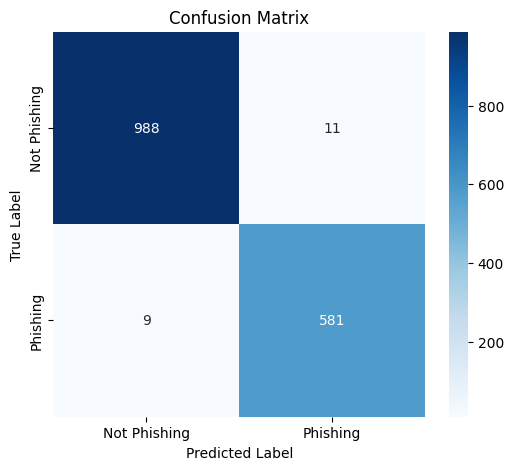

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Your confusion matrix from Epoch 5
conf_matrix = np.array([[988, 11], [9, 581]])

# Define class labels
labels = ["Not Phishing", "Phishing"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
